# Clustering, cluster visualization and clustering evaluation

Outline of this notebook: Do K-means, G-MM and DBSCAN clustering on the latent space, obtain the clustering assignments, then do PCA on the latent space values and plot them according to their clustering assignment. Reports and basic accuracy metric that assumes the clustering is mostly correct, and just counts the small differences from the true labels. Uses the homework 3 data as dummy data, and takes the HMM labels from the assignment as being the true labels. Note that we get graphs that look just like the assignment, but it's missleading because we actually do PCA on the data first and PCA on a 2d space just rotates it, so for 10 dimensional space this will probably be a bit messy, but the accuracy metric will still work.

In [37]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
X = np.loadtxt("hwk3data/EMGaussian.train")
y = np.loadtxt("hwk3data/HMMlabels.train")
k = 4

In [73]:
#a somple accuracy metric, makes a confusion matrix and takes then 
# maximum column-wise value as being the "correct" prediction (assumes
# that the clusters are at least close to right)
def accuracy(test_labels, pred_labels):
    matrix = np.zeros((k,k))
    for (test, pred) in zip(test_labels, pred_labels):
        matrix[int(test)][int(pred)] += 1
    
    maxes = np.amax(matrix, axis=1)
    return np.sum(maxes)/np.sum(matrix)

In [74]:
#K-Means Alg
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=200, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')
kmeans.fit(X)
centroids = kmeans.cluster_centers_
print(centroids)
km_labels = kmeans.predict(X)

[[ 3.36449672 -2.65646983]
 [-3.78479953 -4.21639713]
 [ 3.80280826  5.10467248]
 [-2.23856221  4.16339661]]


In [75]:
#GMM Alg
gmm = GaussianMixture(n_components=k, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=10, init_params='kmeans', weights_init=None, means_init=centroids, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)
gmm.fit(X)
print(gmm.means_)
print(gmm.covariances_)
gmm_labels = gmm.predict(X)

[[ 3.80431163 -3.76957759]
 [-3.07363918 -3.54584944]
 [ 3.97490126  3.85381461]
 [-2.03740532  4.16850216]]
[[[ 0.90861762  0.06420712]
  [ 0.06420712  1.92902866]]

 [[ 6.18340834  5.9943191 ]
  [ 5.9943191   6.12862912]]

 [[ 0.21342418  0.29240607]
  [ 0.29240607 11.85301844]]

 [[ 2.88959766  0.18958681]
  [ 0.18958681  2.75084856]]]


In [76]:
#DBScan Alg
dbsc = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)
dbsc_labels = dbsc.fit_predict(X)

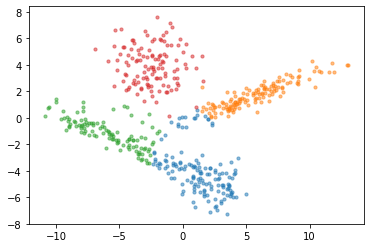

In [77]:
#PCA on X, showing K-means labels
pca = PCA(2)
x = pca.fit_transform(X=X)
fig, ax = plt.subplots()
for i in range(len(x)):
    scatter = ax.scatter(x=x[np.argwhere(km_labels == i)].T[0], y=x[np.argwhere(km_labels == i)].T[1], s=10, alpha=0.5)

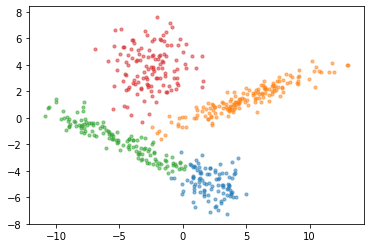

In [78]:
#PCA on X, showing GMM labels
pca = PCA(2)
x = pca.fit_transform(X=X)
fig, ax = plt.subplots()
for i in range(len(x)):
    scatter = ax.scatter(x=x[np.argwhere(gmm_labels == i)].T[0], y=x[np.argwhere(gmm_labels == i)].T[1], s=10, alpha=0.5)

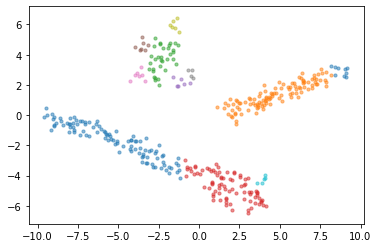

In [79]:
#PCA on X, showing DBSCAN labels
pca = PCA(2)
x = pca.fit_transform(X=X)
fig, ax = plt.subplots()
for i in range(len(x)):
    scatter = ax.scatter(x=x[np.argwhere(dbsc_labels == i)].T[0], y=x[np.argwhere(dbsc_labels == i)].T[1], s=10, alpha=0.5)

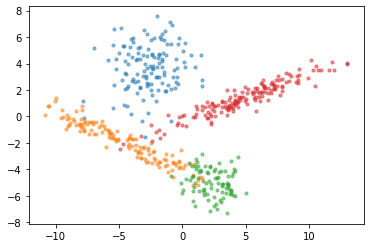

In [80]:
#PCA on X, showing true labels
pca = PCA(2)
x = pca.fit_transform(X=X)
fig, ax = plt.subplots()
for i in range(len(x)):
    scatter = ax.scatter(x=x[np.argwhere(y == i)].T[0], y=x[np.argwhere(y == i)].T[1], s=10, alpha=0.5)

In [83]:
print(accuracy(y, km_labels))
print(accuracy(y, gmm_labels))
print(accuracy(y, y))

0.85
0.964
1.0
